## inference

### preprocess

In [1]:
import cv2
import numpy as np
import torch

In [2]:
im_path = '/Users/kanstantsin/Downloads/sp-test8.jpg'
orig_img = cv2.imread(im_path)
img = cv2.resize(orig_img, (1280, 1280))
img = img.transpose(2, 0, 1)[::-1].reshape(1, 3, 1280, 1280)
img = img.astype(np.float32)
img /= 255
img = torch.tensor(img)
threshold = 0.15
input_data = (img, threshold)

### load model

In [3]:
from ultralytics.nn.autobackend import AutoBackend
from ultralytics.yolo.utils.torch_utils import select_device, smart_inference_mode
from ultralytics.yolo.utils.ops import non_max_suppression

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dnn = False
data = ''
half = False
device = select_device(device)
# path to the model weights
# model_name = os.environ['model_name']  # 'best_clmap_0.982_e346.onnx'
weights = "/Users/kanstantsin/Downloads/best_clmap_0.988_e261.pt"
model = AutoBackend(weights, device=device, dnn=dnn, data=data, fp16=half)

Ultralytics YOLOv8.0.96 🚀 Python-3.9.6 torch-2.0.1 CPU
YOLOv5n6u summary (fused): 253 layers, 4125796 parameters, 0 gradients, 7.2 GFLOPs


### predict

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image, sens_thresh = input_data
model.to(device)
model.eval()
with torch.no_grad():
    result = model(image)
    # uncomment for torch script
    # with torch.jit.optimized_execution(True, {'target_device': 'eia:device ordinal'}):
    #     result = model(image)
    # print(result)
# get confidance score for logging
print(len(result))
conf_score = torch.max(result[0][ :, 4]).item()

print(f'conf score, {conf_score}')
# convert raw model output to list of bounding boxes
result = non_max_suppression(result, conf_thres=sens_thresh, iou_thres=0.45, classes=None, max_det=100)
result_inf = [t.tolist() for t in result]

2
conf score, 0.3420535624027252


### postproc

In [7]:
import sys

sys.path.append('/Users/kanstantsin/workspace/error-detection-client/element-client/utils')
import postproc

In [21]:
print(result_inf)
bbs = np.array(result_inf)
orig_image = postproc.draw_bb(orig_img, bbs, box_disp_conf_thresh=sens_thresh, names=['spag'],
                                colors=postproc.Colors(), model_input_size=(1280,1280))

[[[548.1278076171875, 125.53153991699219, 720.220703125, 402.07855224609375, 0.3420535624027252, 0.0]]]


ValueError: not enough values to unpack (expected at least 2, got 1)

In [18]:
bbs = np.array([[100, 200, 300, 400, 0.5, 0]])
orig_image = postproc.draw_bb(orig_img, bbs, box_disp_conf_thresh=sens_thresh, names=['spag'],
                                colors=postproc.Colors(), model_input_size=(1280,1280))

### display

In [9]:
import matplotlib.pyplot as plt

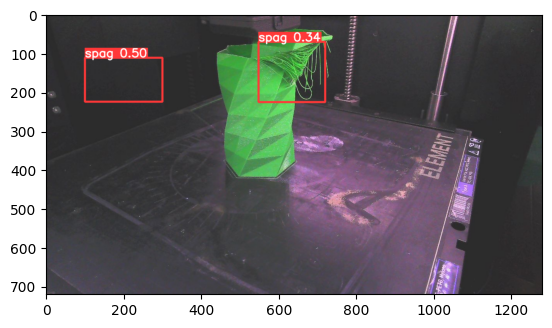

In [19]:
plt.imshow(orig_image[:,:,::-1])

In [ ]:
def get_scaled_bbs_xyxy(img_orig_shape, bbs, model_input_size=(1280, 1280)):
    if len(bbs):
        # Rescale boxes from img_size to im0 size
        bbs[:, :4] = scale_boxes2((model_input_size), bbs[:, :4], img_orig_shape).round()
    return bbs


def scale_boxes2(img1_shape, boxes, img0_shape, ratio_pad=None):
    # Rescale boxes (xyxy) from img1_shape to img0_shape
    gain_x = img0_shape[1] / img1_shape[1]
    gain_y = img0_shape[0] / img1_shape[0]
    boxes[..., [0, 2]] *= gain_x
    boxes[..., [1, 3]] *= gain_y
    clip_boxes(boxes, img0_shape)
    return boxes


def clip_boxes(boxes, shape):
    boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2

In [ ]:
result = get_scaled_bbs_xyxy(img_orig_shape=(720, 1280), bbs=result, model_input_size=(1280, 1280))